## project

In [1]:
import pandas as pd
from math import floor
import numpy as np
from pathlib import Path
import PIL
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array, array_to_img
from matplotlib import pyplot as plt

In [2]:
train_path =Path('dataset/train')
test_path =Path('dataset/test')
val_path = Path('dataset/validation')

In [3]:
image_count = (len(list(train_path.glob('*/*.jpg'))) + 
               len(list(test_path.glob('*/*.jpg'))) +
               len(list(val_path.glob('*/*.jpg'))))
print(image_count)

9208


In [4]:
len(list(train_path.glob('*/*.jpg'))),len(list(test_path.glob('*/*.jpg'))),len(list(val_path.glob('*/*.jpg')))

(6444, 1381, 1383)

In [5]:
batch_size = 64
img_height = 128
img_width = 128

In [6]:
train_ds = image_dataset_from_directory(
  train_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale",
  shuffle=True)

Found 6444 files belonging to 3 classes.


In [7]:
train_ds.class_names

['COVID-19', 'Normal', 'Pneumonia']

In [8]:
test_ds = image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale")

Found 1381 files belonging to 3 classes.


In [9]:
val_ds = image_dataset_from_directory(
  val_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale")

Found 1383 files belonging to 3 classes.


In [10]:
class_names = train_ds.class_names
class_names

['COVID-19', 'Normal', 'Pneumonia']

In [11]:
num_classes = len(class_names)
num_classes

3

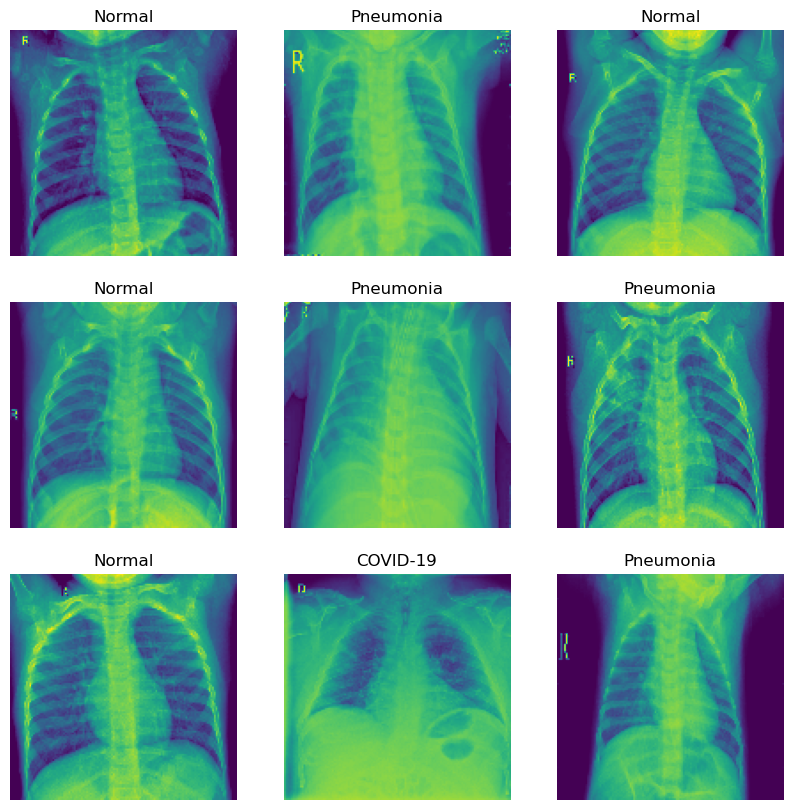

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
class_labels_train = np.concatenate([y for x, y in train_ds], axis=0)
class_labels_train, len(class_labels_train)

(array([1, 2, 2, ..., 2, 2, 2]), 6444)

In [15]:
class_labels = np.unique(class_labels_train)
class_labels

array([0, 1, 2])

In [16]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=class_labels, 
                                                  y=class_labels_train)
class_weights

array([2.39732143, 0.93840105, 0.65909788])

In [17]:
class_weights_dict = {}

for idx, i in enumerate(class_weights):
    class_weights_dict[idx] = i

    
print(class_weights_dict)

{0: 2.3973214285714284, 1: 0.9384010484927916, 2: 0.6590978827861307}


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Reshape,MaxPooling2D, Flatten, BatchNormalization, Resizing, Rescaling, Lambda, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [77]:
model = Sequential()
model.add(Input(shape=(None, None, 1)))

model.add(Resizing(128, 128))
model.add(Rescaling(1./255))

model.add(Conv2D(32, (3, 3), activation='relu',))
model.add(MaxPooling2D(4,4))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['Accuracy'])

In [78]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 128, 128, 1)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                

In [73]:
checkpoint = ModelCheckpoint(filepath="PneumoniaModel.keras",
                             monitor='val_loss', save_best_only=True,
                             save_weights_only=False,
                             verbose=3)

earlystopper = EarlyStopping(monitor='val_loss', patience=4)

callbackslist = [checkpoint, earlystopper]

In [74]:
model.fit(train_ds, validation_data=test_ds, epochs=50, callbacks=callbackslist, class_weight=class_weights_dict)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_9/lambda_6/rgb_to_grayscale/Tensordot/MatMul' defined at (most recent call last):
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\hsyem\AppData\Local\Temp\ipykernel_4868\1452258182.py", line 1, in <module>
      model.fit(train_ds, validation_data=test_ds, epochs=50, callbacks=callbackslist, class_weight=class_weights_dict)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hsyem\anaconda3\envs\mlenv\lib\site-packages\keras\layers\core\lambda_layer.py", line 208, in call
      result = self.function(inputs, **kwargs)
    File "C:\Users\hsyem\AppData\Local\Temp\ipykernel_4868\4002891288.py", line 5, in <lambda>
      model.add(Lambda(lambda x: tf.image.rgb_to_grayscale(x)))
Node: 'sequential_9/lambda_6/rgb_to_grayscale/Tensordot/MatMul'
Matrix size-incompatible: In[0]: [1048576,1], In[1]: [3,1]
	 [[{{node sequential_9/lambda_6/rgb_to_grayscale/Tensordot/MatMul}}]] [Op:__inference_train_function_18723]

In [26]:
train_loss, train_acc = model.evaluate(train_ds, verbose = 0)
test_loss, test_acc = model.evaluate(test_ds, verbose = 0)
val_loss, val_acc = model.evaluate(val_ds, verbose = 0)

In [27]:
print("Training Accuracy: %5.2f\nTraining Loss: %5.2f \n"%(train_acc*100, train_loss))
print("Testing Accuracy: %5.2f \nTesting Loss: %5.2f \n"%(test_acc*100, test_loss))
print("Val Accuracy: %5.2f \nVal Loss: %5.2f"%(val_acc*100, val_loss))

Training Accuracy: 98.91
Training Loss:  0.04 

Testing Accuracy: 97.18 
Testing Loss:  0.13 

Val Accuracy: 96.82 
Val Loss:  0.13


In [28]:
model.save("Pneumonia.keras")

In [29]:
# import tensorflow as tf
# tf.keras.models.save_model(model, "BrainTumorsModels.keras")

In [30]:
loaded_model = tf.keras.models.load_model("Pneumonia.keras")

In [31]:
true_y = np.concatenate([y for x, y in val_ds])
true_y, len(true_y)

(array([2, 2, 1, ..., 2, 1, 2]), 1383)

In [32]:
preds_softmax = loaded_model.predict(val_ds)

22/22 [==============================] - 2s 58ms/step


In [33]:
preds = []
for i in preds_softmax:
    preds.append(np.argmax(i))
#del(preds_softmax)
len(preds)

1383

In [34]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, cohen_kappa_score,f1_score, confusion_matrix

In [35]:
print("Accuracy Score is ",accuracy_score(true_y, preds))
print("Recall Score is ",recall_score(true_y, preds, average='macro'))
print("Precision Score is ",precision_score(true_y, preds, average='macro'))
print("Cohen Kappa Score is ",cohen_kappa_score(true_y, preds))
print("F1 Score is ",f1_score(true_y, preds, average='macro'))
print("Confusion Matrix is \n",confusion_matrix(true_y, preds))

Accuracy Score is  0.9681851048445409
Recall Score is  0.9746990221233646
Precision Score is  0.9632322835028018
Cohen Kappa Score is  0.9472344292487678
F1 Score is  0.9686308740678579
Confusion Matrix is 
 [[191   1   1]
 [  3 482   6]
 [  6  27 666]]


We need to apply the same preprocessing techniques we used for the training data to any new image.
Here are the steps to processing new images.
* Resize the image to be of 128x128 dimensions. 
* Convert the image to grayscale.
* Expand image dimensions to take the following form, (batch_size, img_height, img_width, num_channels)

In [53]:
def prediction(image):
    image = image.convert("L")
    image = (np.expand_dims(image,0))
    predictions = loaded_model.predict(image, verbose=0)
    pred=np.argmax(predictions)
    return pred

In [54]:
def prediction_decode(image):
    image_resized = image_resized.convert("L")
    image_resized = (np.expand_dims(image_resized,0))
    predictions = loaded_model.predict(image_resized, verbose=0)
    pred=np.argmax(predictions)
    return class_names[pred]

In [56]:
from PIL import Image
img=Image.open("dataset/validation/COVID-19/COVID-19 (1).jpg")
prediction(img), prediction_decode(img)

(0, 'COVID-19')

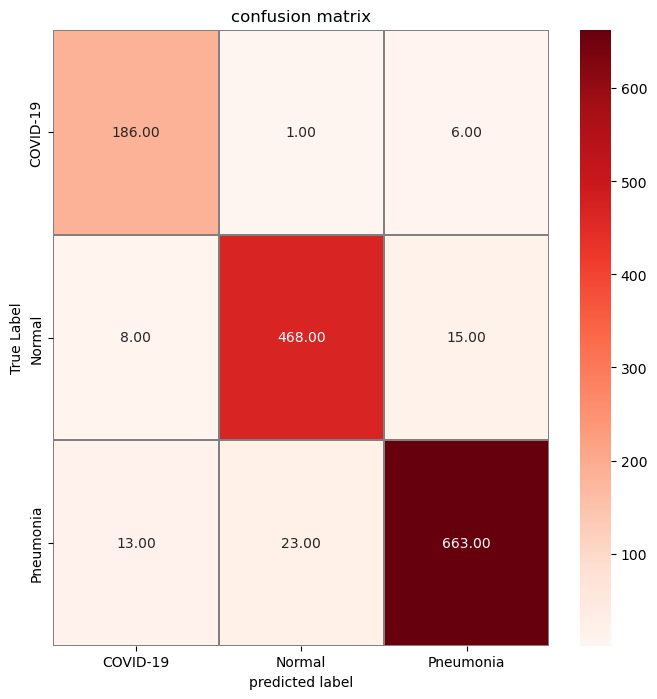

In [98]:
confusion_mtx = confusion_matrix(true_y, preds)
target_names = class_names
plt.figure(figsize = (8,8))
sns.heatmap(confusion_mtx,cmap= "Reds", linecolor = 'gray' , linewidth = 0.01 , annot = True, fmt='.2f' , xticklabels = target_names , yticklabels = target_names)
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()